# Imports and Device

In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Load the data

In [3]:
root_path = "/scratch/04703/sravula/UTAFSDataNew/new_data"
chip_num = 2

In [4]:
import utils

data_dict = utils.grab_chip_data(root_path, chip_num, resample=True)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs', 'og_matrix', 'og_freqs'])

In [6]:
print(data_dict['gt_matrix'].shape)
print(data_dict['vf_matrix'].shape)
print(data_dict['y_matrix'].shape)
print(data_dict['og_matrix'].shape)

(1024, 4, 4, 2)
(581, 4, 4, 2)
(14, 4, 4, 2)
(581, 4, 4, 2)


In [7]:
print(data_dict['gt_freqs'].shape)
print(data_dict['y_freqs'].shape)
print(data_dict['og_freqs'].shape)

(1024,)
(14,)
(581,)


In [8]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])
og_data = utils.matrix_to_sparams(data_dict['og_matrix'])

In [9]:
print(vf_data.shape)
print(gt_data.shape)
print(y_data.shape)
print(og_data.shape)

(10, 2, 581)
(10, 2, 1024)
(10, 2, 14)
(10, 2, 581)


In [10]:
og_freqs = data_dict['og_freqs']
gt_freqs = data_dict['gt_freqs']

In [11]:
print(og_freqs.shape)
print(gt_freqs.shape)

(581,)
(1024,)


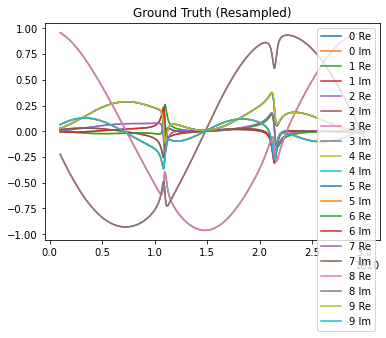

In [12]:
n_sparams = gt_data.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(gt_freqs, gt_data[i,1,:].squeeze(), label=str(i)+" Im")
plt.legend()
plt.title("Ground Truth (Resampled)")
plt.show()

In [13]:
gt_mag = utils.to_mag(torch.from_numpy(gt_data))

print(gt_mag.shape)

torch.Size([10, 1024])


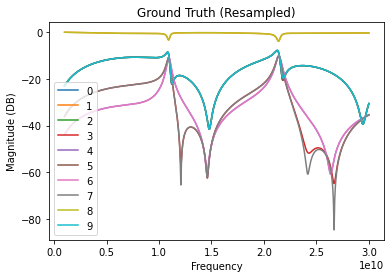

In [14]:
n_sparams = gt_mag.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_mag[i], label=str(i))
plt.legend()
plt.title("Ground Truth (Resampled)")
plt.ylabel("Magnitude (DB)")
plt.xlabel("Frequency")
plt.show()

### Check the data for some smoothness and regularity conditions

In [15]:
def calc_diffs(x, order=1):
    if order > 1:
        x = calc_diffs(x, order-1)
    
    if isinstance(x, np.ndarray):
        return (x - np.roll(x, -1, 2))[...,:-1] 
    elif torch.is_tensor(x):
        return (x - torch.roll(x, -1, 2))[...,:-1]

(10, 2, 1023)


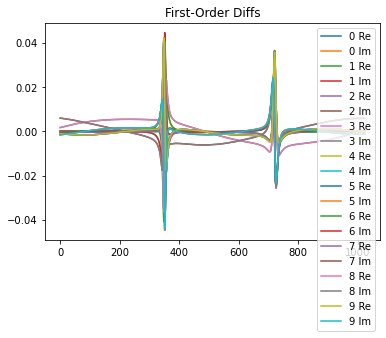

In [16]:
x_diff_1 = calc_diffs(gt_data)

print(x_diff_1.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_1[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_1[i,1,:].squeeze(), label=str(i)+" Im")
plt.legend()
plt.title("First-Order Diffs")
plt.show()

(10, 2, 1022)


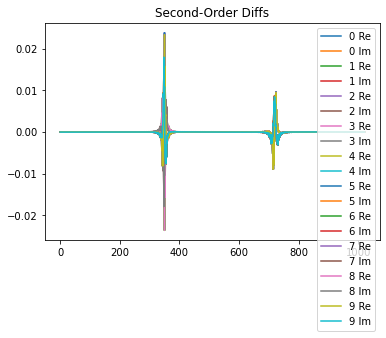

In [17]:
x_diff_2 = calc_diffs(gt_data, 2)

print(x_diff_2.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_2[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_2[i,1,:].squeeze(), label=str(i)+" Im")
plt.legend()
plt.title("Second-Order Diffs")
plt.show()

## Do some checks for Causality and Passivity

gt_data_torch = torch.from_numpy(gt_data)
gt_data_complex = torch.complex(gt_data_torch[:,0,:], gt_data_torch[:,1,:])

print(gt_data_complex.shape)
print(gt_data_complex.dtype)
print(gt_data_complex.device)

num_sparams, num_freqs = gt_data_complex.shape

gt_data_complex = gt_data_complex.to(device)
irfft_true = torch.fft.irfft(gt_data_complex, n=num_freqs*2-1, dim=-1, norm="ortho")
irfft_true = irfft_true.cpu()

print(irfft_true.shape)
print(irfft_true.dtype)
print(irfft_true.device)

plt.figure()
for i in range(num_sparams):
    plt.plot(irfft_true[i,:], label=str(i))
plt.legend()
plt.show()

## Grab some measurements

In [18]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full]
LENGTH = len(gt_freqs)
M = 10

In [19]:
kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, LENGTH, M)

In [20]:
print(LENGTH)
print(M)
print(len(kept_inds))
print(len(missing_inds))

1024
10
11
1013


## Make the final data

In [21]:
x = torch.from_numpy(gt_data).type(torch.float32)
x = x.view(-1, LENGTH).unsqueeze(0)

In [22]:
print(x.shape)

torch.Size([1, 20, 1024])


In [23]:
y = torch.clone(x)[:, :, kept_inds]

In [24]:
print(y.shape)

torch.Size([1, 20, 11])


## Make sure that we can transform it back to the OG shape/size

In [25]:
x_temp = utils.sparams_to_matrix(x)

In [26]:
print(x_temp.shape)
print(x_temp.dtype)
print(x_temp.device)

torch.Size([1024, 4, 4, 2])
torch.float32
cpu


In [27]:
diff = x_temp - torch.from_numpy(data_dict['gt_matrix']).type(torch.float32)

print(torch.mean(diff).item())

0.007141662295907736


## Visualize the data and observations

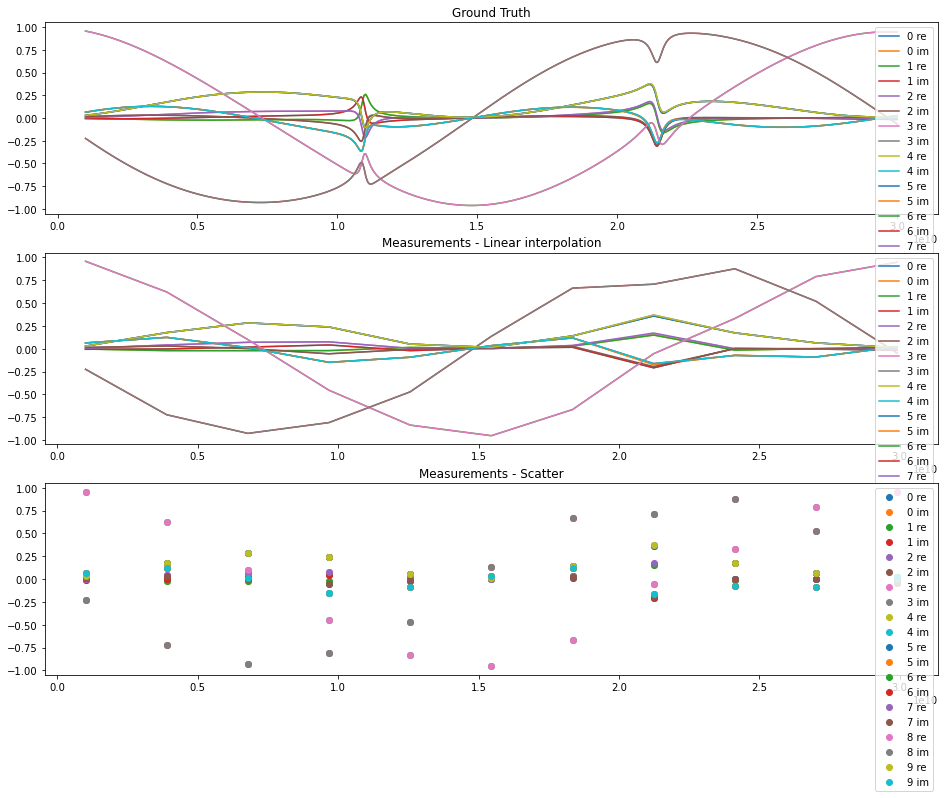

In [28]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
axes[0].set_title("Ground Truth")
axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs[kept_inds], y[j,i,:].flatten(), label=label)
axes[1].set_title("Measurements - Linear interpolation")
axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].scatter(gt_freqs[kept_inds], y[j,i,:].flatten(), label=label)
axes[2].set_title("Measurements - Scatter")
axes[2].legend()

plt.show()

In [29]:
x_mag = utils.to_mag(x)
y_mag = utils.to_mag(y)

print(x_mag.shape)
print(y_mag.shape)

torch.Size([10, 1024])
torch.Size([10, 11])


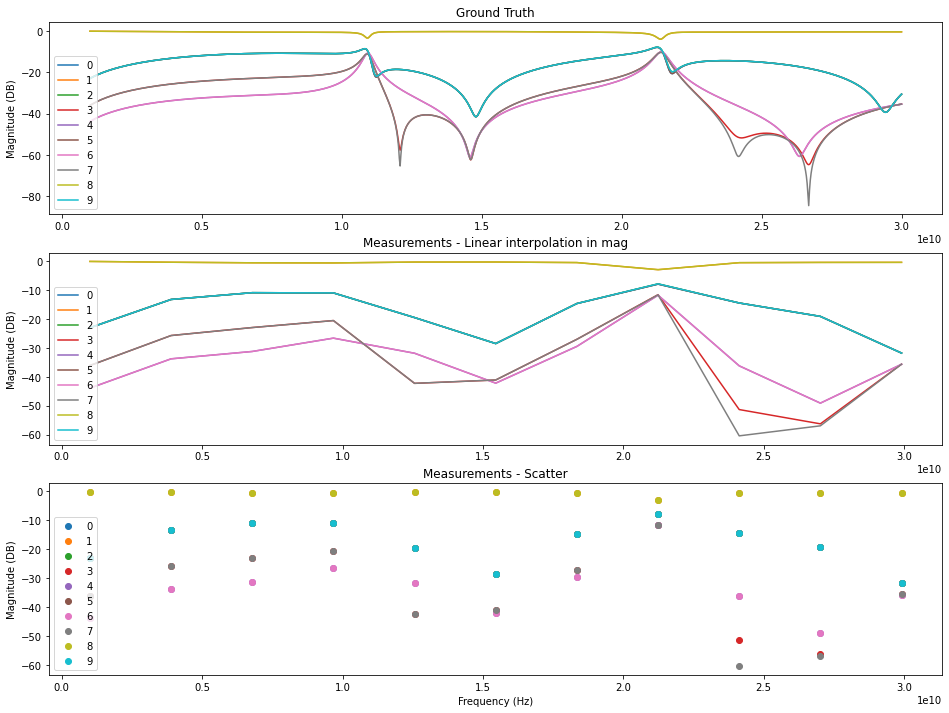

In [30]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs[kept_inds], y_mag[j], label=str(j))
axes[1].set_title("Measurements - Linear interpolation in mag")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].scatter(gt_freqs[kept_inds], y_mag[j], label=str(j))
axes[2].set_title("Measurements - Scatter")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()

plt.show()

# Set up the network

In [31]:
LR = 1e-4 # learning rate
NUM_ITER = 50000 # number iterations

NZ = y.shape[1]
NUM_LAYERS = int(np.ceil(np.log2(LENGTH))) - 2
NGF = [int(256 * 2**(i/2)) for i in range(NUM_LAYERS)]

BS = y.shape[0]
NC = y.shape[1]

In [32]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)

NZ:  20
NUM_LAYERS:  8
NGF:  [256, 362, 512, 724, 1024, 1448, 2048, 2896]
BS:  1
NC:  20


In [33]:
from models import RES_UNET

KERNEL_SIZE = 1

net = RES_UNET(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC, kernel_size=KERNEL_SIZE, num_layers=NUM_LAYERS)
net = net.to(device)

In [34]:
test_out = net.forward_with_z()
print(test_out.shape)

torch.Size([1, 20, 1024])


/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [35]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  93645112


# (Testing) Fit Interp

In [36]:
import scipy

y_np = y.cpu().detach().numpy()

Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')

In [37]:
y_interp = Interpolate(np.arange(LENGTH))

print(y_interp.shape)

(1, 20, 1024)


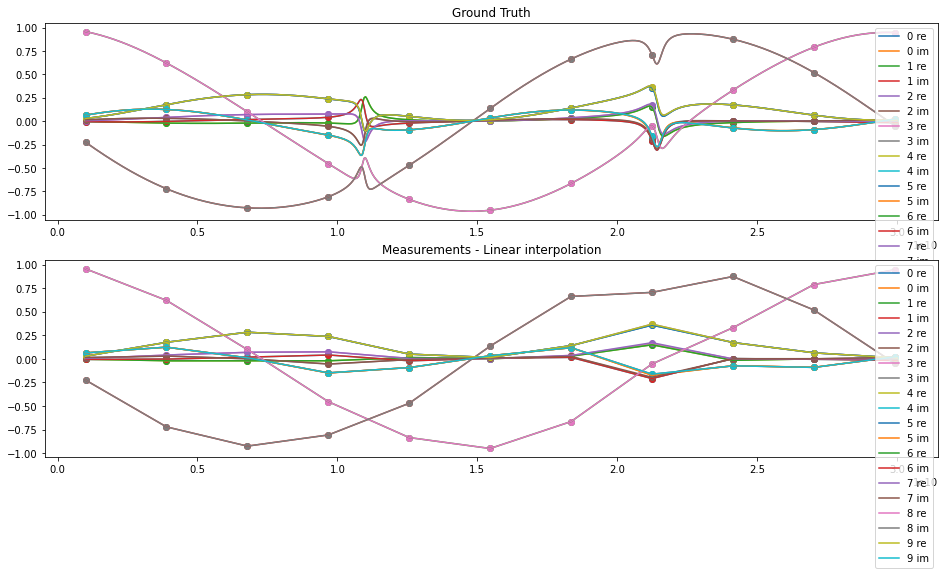

In [38]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, y_interp[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Measurements - Linear interpolation")
axes[1].legend()

plt.show()

In [39]:
y_interp_mag = utils.to_mag(torch.from_numpy(y_interp))

print(y_interp_mag.shape)

torch.Size([10, 1024])


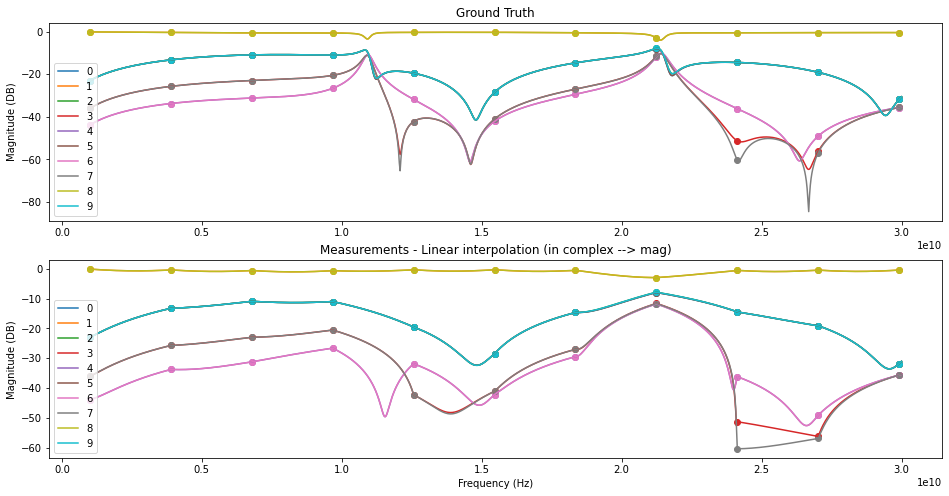

In [40]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j])
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j])
axes[1].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].legend()

plt.show()

In [41]:
net.set_z(y_interp)

y_interp = torch.from_numpy(y_interp).type(torch.float32)
y_interp = y_interp.to(device)

criterion = torch.nn.MSELoss()
criterion = criterion.to(device)

net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

NUM_ITER_PRETRAIN = 1000

train_losses = []

tic = time.time()
for i in range(NUM_ITER_PRETRAIN):
    net.perturb_noise(0.01) 
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    train_loss = criterion(out, y_interp)
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        train_losses.append(train_loss.item())

        if (i+1)%100 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

out = out.detach().cpu().numpy()

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
axes[0].set_title("Ground Truth")
axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
axes[1].set_title("Last Output")
axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs, y_interp[j,i,:].cpu().flatten(), label=label)
axes[2].set_title("Measurements - Linear interpolation")
axes[2].legend()

plt.show()

out_mag = utils.to_mag(torch.from_numpy(out))

print(out_mag.shape)

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, out_mag[j], label=str(j))
axes[1].set_title("Last Output")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
#     axes[2].plot(gt_freqs[kept_inds], y_mag[j], label=str(j))
axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()

plt.show()

max_idx = 100

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

# Run

In [42]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=True, reduction="sum")
criterion = criterion.to(device)

In [43]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

train_losses = []
test_mses = []
test_maes = []
outputs = []

x = x.to(device)
y = y.to(device)

In [44]:
tic = time.time()
for i in range(NUM_ITER):
    
    optim.zero_grad()
    
    out = net.forward_with_z()
    train_loss = criterion(out, y) 
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        outputs.append(out.detach().clone().cpu())
        train_losses.append(train_loss.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%1000 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            print()

/scratch/04703/sravula/conda_local/envs/devito-base/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ITER  0
TIME:  0.15092968940734863

ITER  999
TIME:  41.736939430236816

ITER  1999
TIME:  83.28376364707947

ITER  2999
TIME:  124.64835381507874

ITER  3999
TIME:  165.98519778251648

ITER  4999
TIME:  207.37335586547852

ITER  5999
TIME:  248.8324773311615

ITER  6999
TIME:  290.38641834259033

ITER  7999
TIME:  331.9485559463501

ITER  8999
TIME:  373.49409103393555

ITER  9999
TIME:  415.1711781024933

ITER  10999
TIME:  456.8646545410156

ITER  11999
TIME:  498.5772535800934

ITER  12999
TIME:  540.317170381546

ITER  13999
TIME:  582.101155757904

ITER  14999
TIME:  623.8900306224823

ITER  15999
TIME:  665.6489660739899

ITER  16999
TIME:  707.4581425189972

ITER  17999
TIME:  749.3215897083282

ITER  18999
TIME:  791.16668009758

ITER  19999
TIME:  833.0767271518707

ITER  20999
TIME:  875.072586774826

ITER  21999
TIME:  917.0109541416168

ITER  22999
TIME:  958.9394118785858

ITER  23999
TIME:  1000.8401608467102

ITER  24999
TIME:  1042.7955865859985

ITER  25999
TIME:  108

# Plot the last and best outputs and the metrics

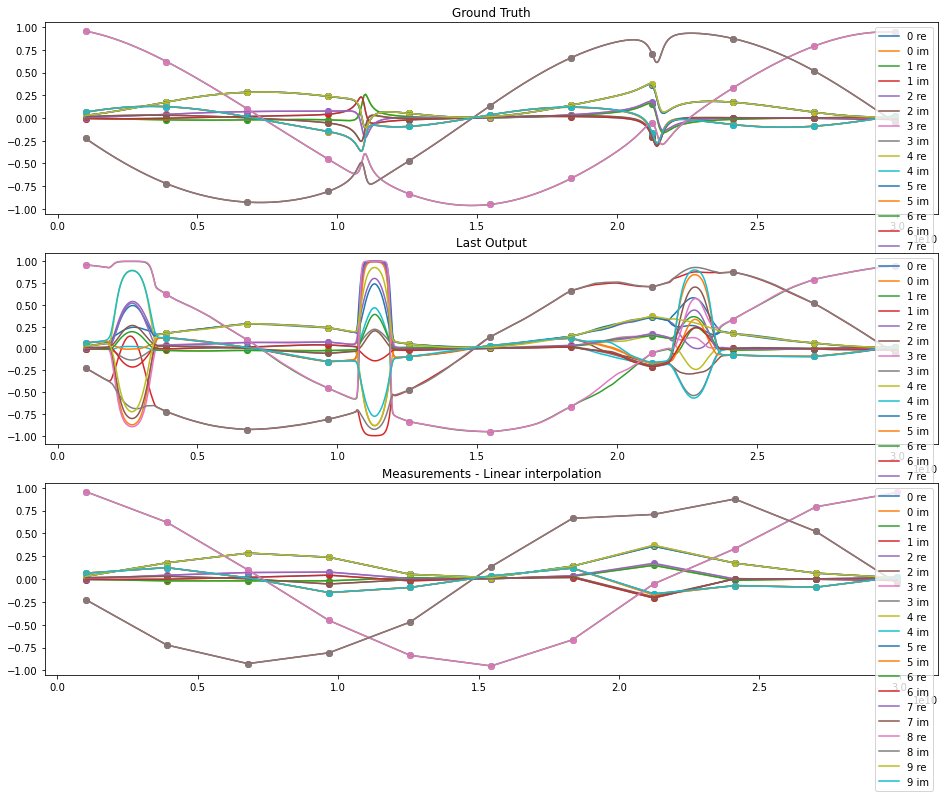

In [45]:
out = outputs[-1]

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Last Output")
axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten(), label=label)
        axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[2].set_title("Measurements - Linear interpolation")
axes[2].legend()

plt.show()

In [46]:
out_mag = utils.to_mag(out)

print(out_mag.shape)

torch.Size([10, 1024])


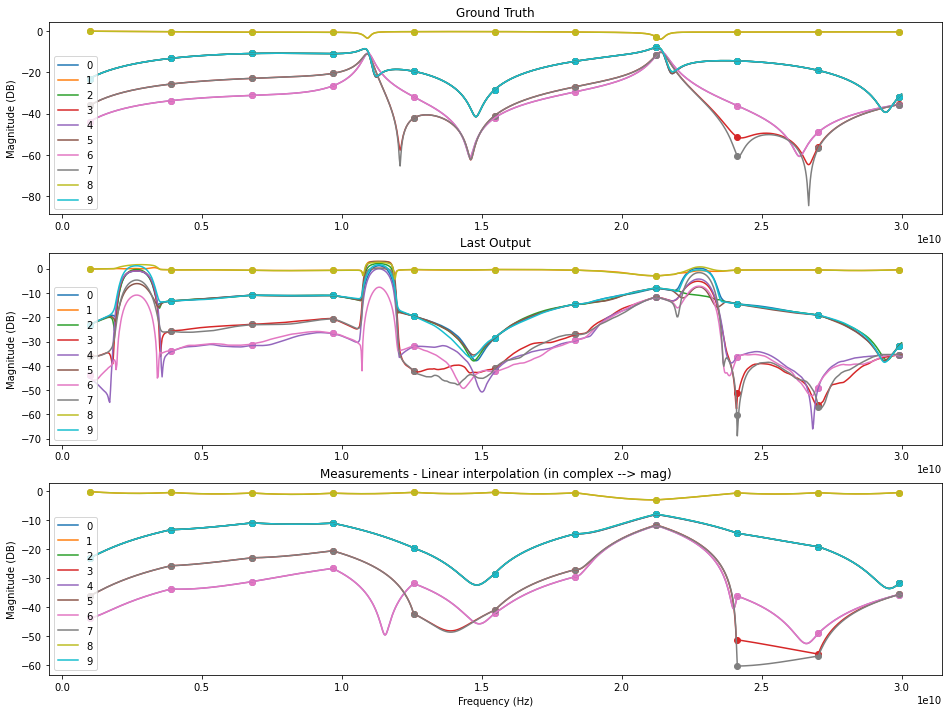

In [47]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, out_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[1].set_title("Last Output")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[2].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()

plt.show()

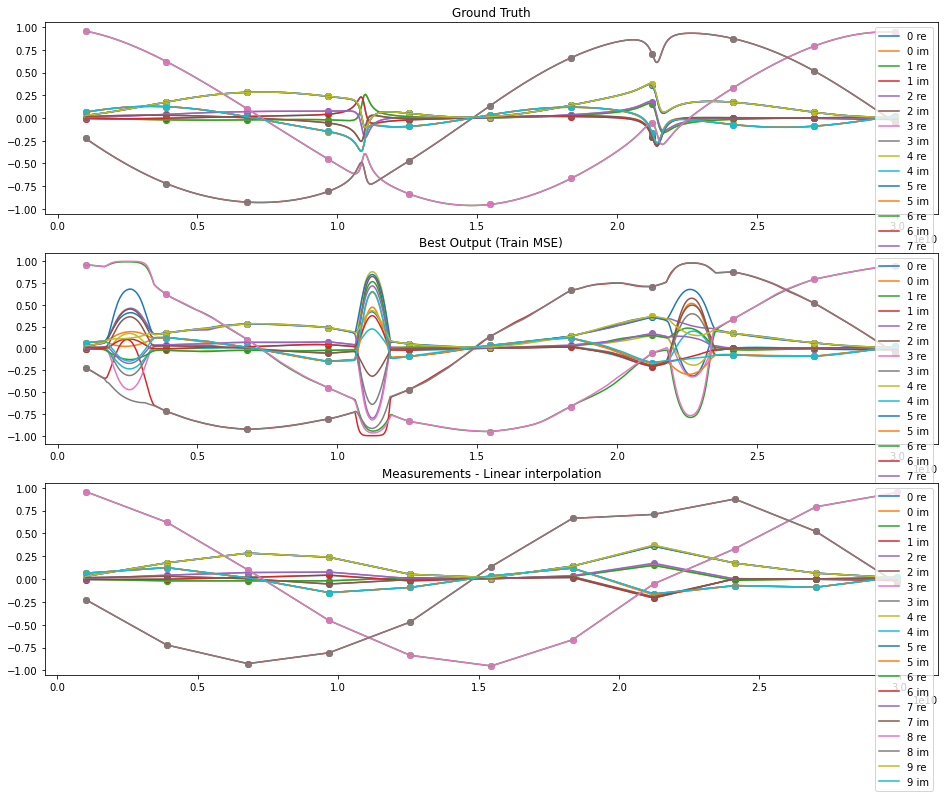

In [48]:
out = outputs[np.argmin(train_losses)]

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Best Output (Train MSE)")
axes[1].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten(), label=label)
        axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[2].set_title("Measurements - Linear interpolation")
axes[2].legend()

plt.show()

In [49]:
out_mag = utils.to_mag(out)

print(out_mag.shape)

torch.Size([10, 1024])


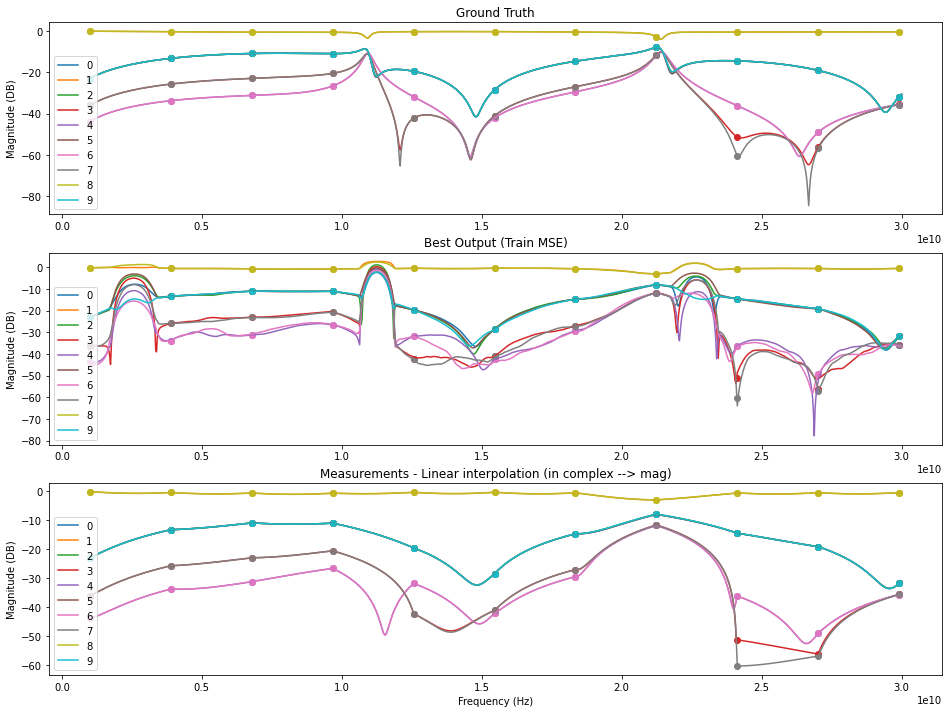

In [50]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for j in range(x_mag.shape[0]):
    axes[0].plot(gt_freqs, x_mag[j], label=str(j))
    axes[0].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[0].set_title("Ground Truth")
axes[0].set_ylabel("Magnitude (DB)")
axes[0].legend()

for j in range(x_mag.shape[0]):
    axes[1].plot(gt_freqs, out_mag[j], label=str(j))
    axes[1].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[1].set_title("Best Output (Train MSE)")
axes[1].set_ylabel("Magnitude (DB)")
axes[1].legend()

for j in range(x_mag.shape[0]):
    axes[2].plot(gt_freqs, y_interp_mag[j], label=str(j))
    axes[2].scatter(gt_freqs[kept_inds], y_mag[j].cpu().numpy())
axes[2].set_title("Measurements - Linear interpolation (in complex --> mag)")
axes[2].set_ylabel("Magnitude (DB)")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].legend()

plt.show()

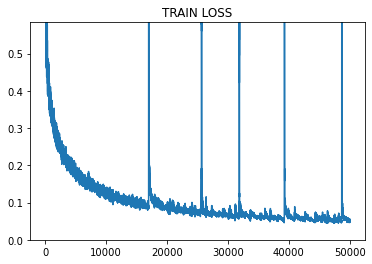

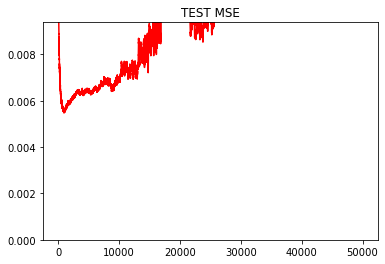

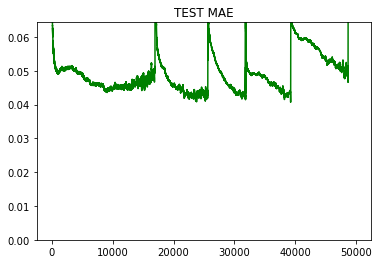

In [51]:
max_idx = 100 #np.argmax(train_losses)

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()